In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torchvision import transforms, models
import cv2

In [4]:
def deeplabv3_resnet101(pretrained=False, progress=True,
                        num_classes=21, aux_loss=None, **kwargs):
    """Constructs a DeepLabV3 model with a ResNet-101 backbone.

    Args:
        pretrained (bool): If True, returns a model pre-trained on COCO train2017 which
            contains the same classes as Pascal VOC
        progress (bool): If True, displays a progress bar of the download to stderr
        num_classes (int): The number of classes
        aux_loss (bool): If True, include an auxiliary classifier
    """
    return _load_model('deeplabv3', 'resnet101', pretrained, progress, num_classes, aux_loss, **kwargs)

In [5]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

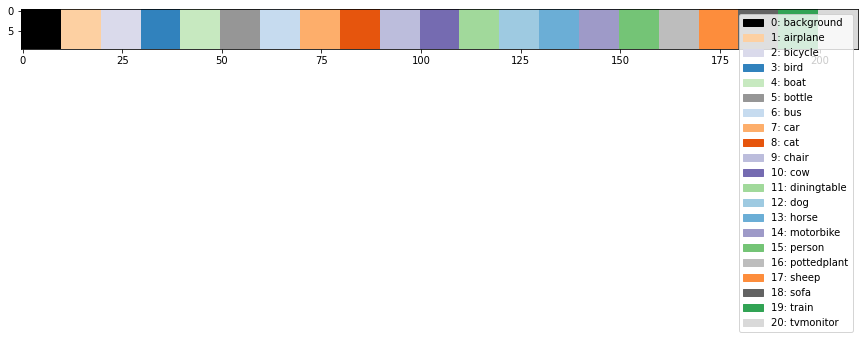

In [6]:

labels = ['background', 'airplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
          'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

cmap = plt.cm.get_cmap('tab20c')
colors = (cmap(np.arange(cmap.N)) * 255).astype(np.int)[:, :3].tolist()
np.random.seed(27)
np.random.shuffle(colors)
colors.insert(0, [0, 0, 0]) # 배경색
colors = np.array(colors, dtype=np.uint8)

# 컬러 팔레드 생성
palette_map = np.empty((10, 0, 3), dtype=np.uint8)
legend = []

for i in range(21):
    legend.append(mpatches.Patch(color=np.array(colors[i]) / 255., label='%d: %s' % (i, labels[i])))
    c = np.full((10, 10, 3), colors[i], dtype=np.uint8)
    palette_map = np.concatenate([palette_map, c], axis=1)

plt.figure(figsize=(15, 2))
plt.legend(handles=legend)
plt.imshow(palette_map)

In [9]:
def segment(net, img):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    output = model(input_batch)['out'][0] # (21, height, width)

    output_predictions = output.argmax(0).byte().cpu().numpy() # (height, width) 

    r = Image.fromarray(output_predictions).resize((img.shape[1], img.shape[0]))
    r.putpalette(colors)

    return r, output_predictions

In [10]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving puppy.jpg to puppy (1).jpg
User uploaded file "puppy.jpg" with length 178975 bytes


In [11]:
ls -al

total 368
drwxr-xr-x 1 root root   4096 Sep 15 08:31  ./
drwxr-xr-x 1 root root   4096 Sep 15 08:24  ../
drwxr-xr-x 4 root root   4096 Sep  1 19:26  .config/
-rw-r--r-- 1 root root 178975 Sep 15 08:31 'puppy (1).jpg'
-rw-r--r-- 1 root root 178975 Sep 15 08:26  puppy.jpg
drwxr-xr-x 1 root root   4096 Sep  1 19:26  sample_data/


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


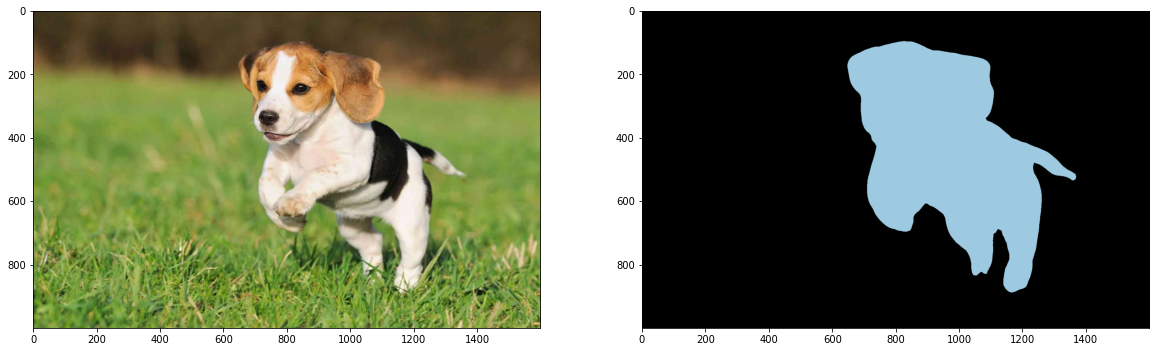

In [12]:
img = np.array(Image.open('puppy.jpg'))

fg_h, fg_w, _ = img.shape

segment_map, pred = segment(model, img)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(segment_map)

In [13]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving sunset.jpg to sunset.jpg
User uploaded file "sunset.jpg" with length 160275 bytes


In [14]:
ls -al

total 528
drwxr-xr-x 1 root root   4096 Sep 15 08:51  ./
drwxr-xr-x 1 root root   4096 Sep 15 08:24  ../
drwxr-xr-x 4 root root   4096 Sep  1 19:26  .config/
-rw-r--r-- 1 root root 178975 Sep 15 08:31 'puppy (1).jpg'
-rw-r--r-- 1 root root 178975 Sep 15 08:26  puppy.jpg
drwxr-xr-x 1 root root   4096 Sep  1 19:26  sample_data/
-rw-r--r-- 1 root root 160275 Sep 15 08:51  sunset.jpg


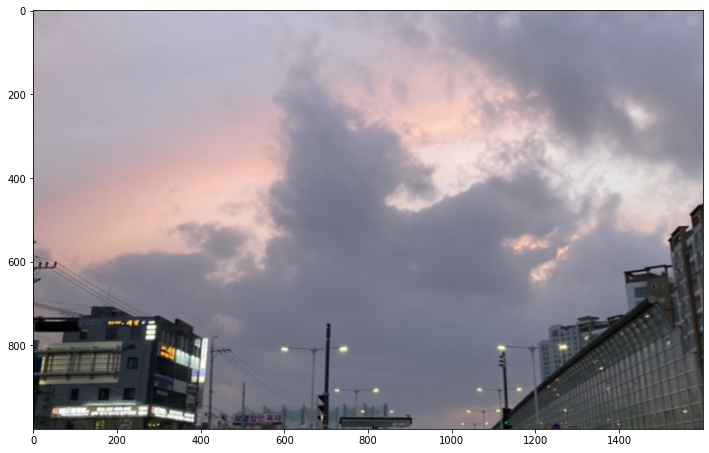

In [15]:
background = np.array(Image.open('sunset.jpg'))

bg_h, bg_w, _ = background.shape

# fit to fg width
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))

bg_h, bg_w, _ = background.shape

margin = (bg_h - fg_h) // 2

if margin > 0:
    background = background[margin:-margin, :, :]
else:
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin), left=0, right=0, borderType=cv2.BORDER_REPLICATE)

# final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))

plt.figure(figsize=(12, 8))
plt.imshow(background)

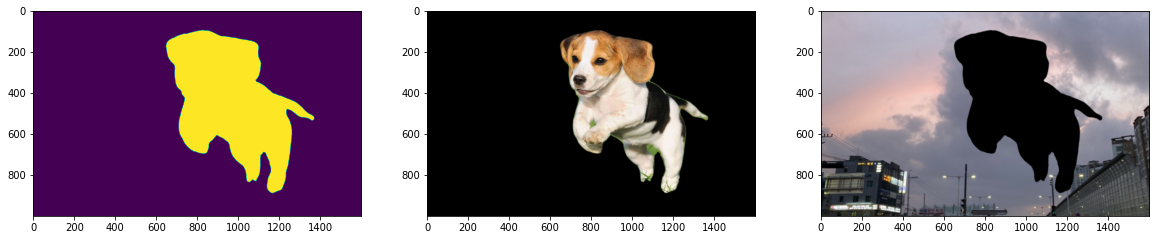

In [16]:
mask = (pred == 12).astype(float) * 255 # 12 : dog
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255. # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))  

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))

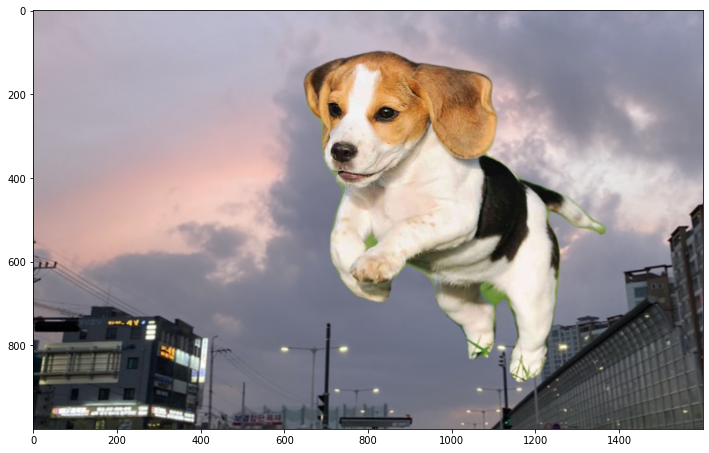

In [17]:

result = cv2.add(foreground, background).astype(np.uint8)

Image.fromarray(result).save('result.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(result)

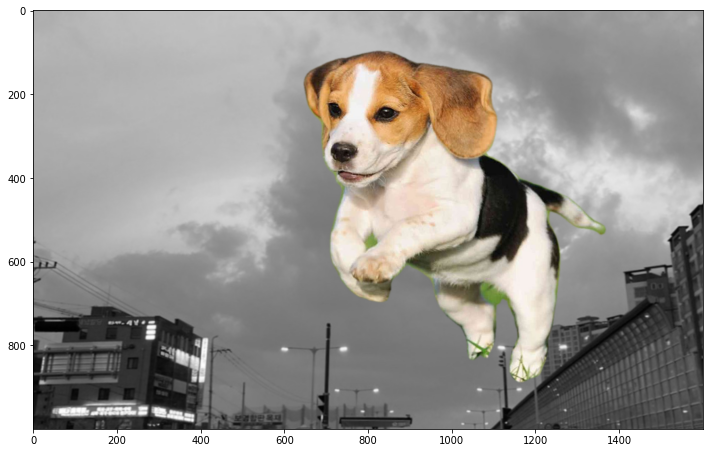

In [18]:
gray_background = cv2.cvtColor(background.astype(np.uint8), cv2.COLOR_BGR2GRAY)
gray_background = cv2.cvtColor(gray_background, cv2.COLOR_GRAY2BGR).astype(float)

gray_result = cv2.add(foreground, gray_background).astype(np.uint8)

Image.fromarray(gray_result).save('result_gray.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(gray_result)

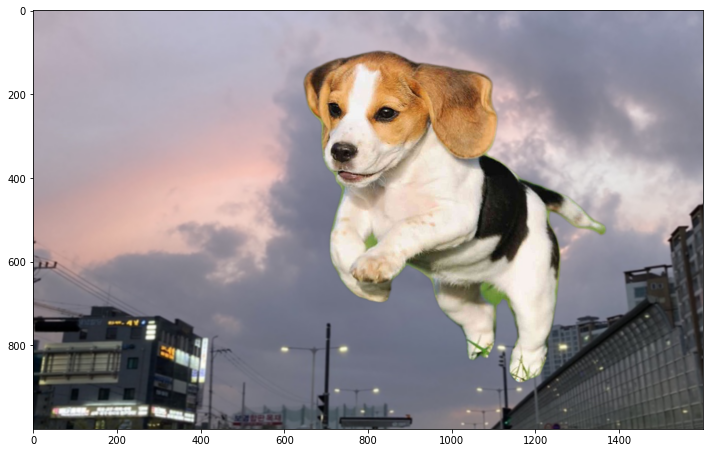

In [19]:
blurred_background = cv2.GaussianBlur(background, (5, 5), 0).astype(float)

bluured_result = cv2.add(foreground, blurred_background).astype(np.uint8)

Image.fromarray(bluured_result).save('result_blurred.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(bluured_result)

In [20]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving son.jpg to son.jpg
User uploaded file "son.jpg" with length 130768 bytes


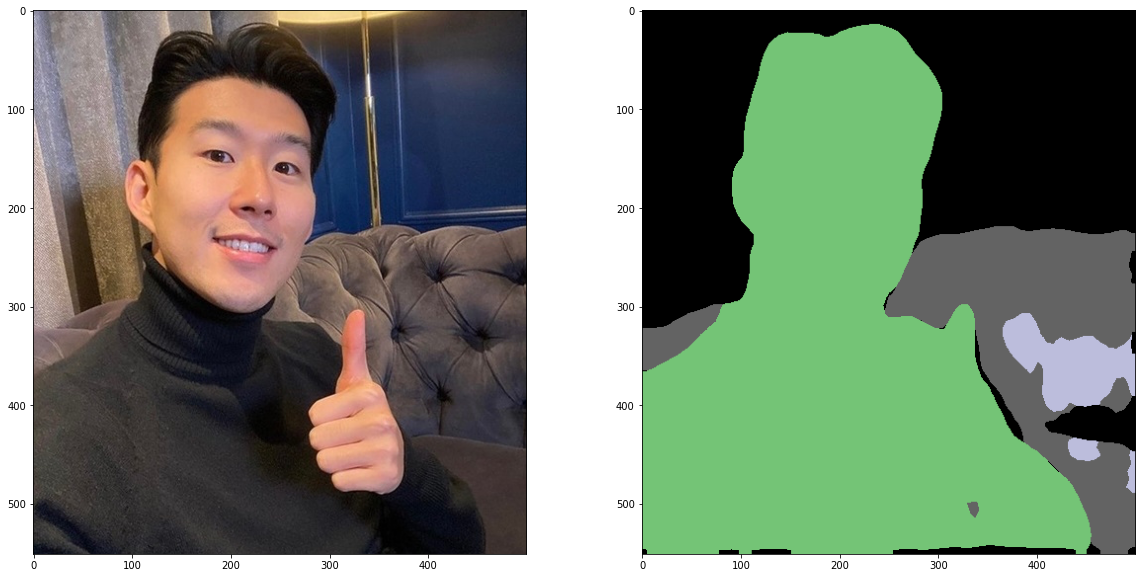

In [21]:
img = np.array(Image.open('son.jpg'))

fg_h, fg_w, _ = img.shape

segment_map, pred = segment(model, img)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(segment_map)

In [22]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving yeosudam.jpg to yeosudam.jpg
User uploaded file "yeosudam.jpg" with length 87132 bytes


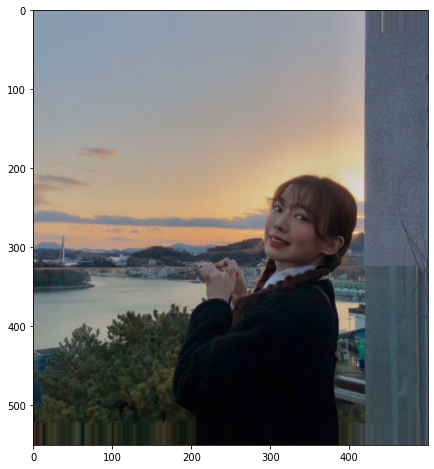

In [23]:
background = np.array(Image.open('yeosudam.jpg'))

bg_h, bg_w, _ = background.shape

# fit to fg width
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))

bg_h, bg_w, _ = background.shape

margin = (bg_h - fg_h) // 2

if margin > 0:
    background = background[margin:-margin, :, :]
else:
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin), left=0, right=0, borderType=cv2.BORDER_REPLICATE)

# final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))

plt.figure(figsize=(12, 8))
plt.imshow(background)

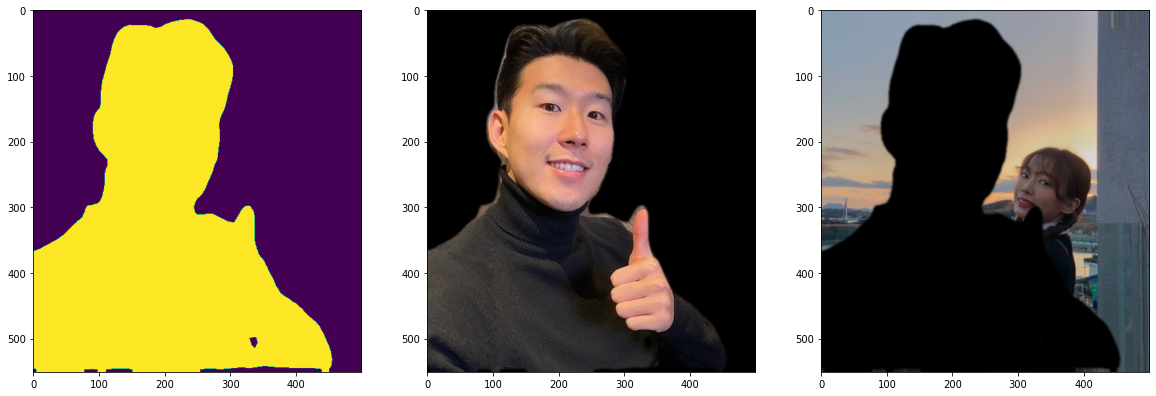

In [24]:
mask = (pred == 15).astype(float) * 255 # 15: person
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255. # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))  

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))

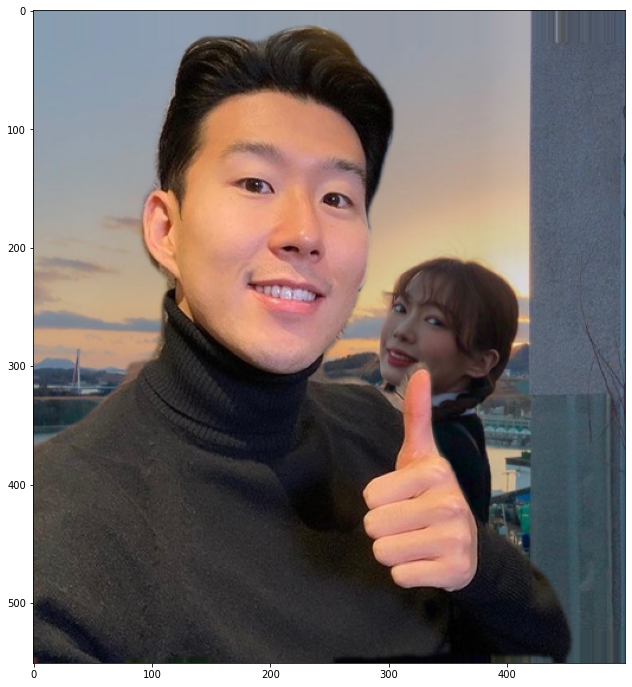

In [25]:
result = cv2.add(foreground, background).astype(np.uint8)

plt.figure(figsize=(12, 12))
plt.imshow(result)